# Description

Simulate gradient descent using the simple function.

In [1]:
!pip install -Uqq fastai

In [2]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

We use a cubic function

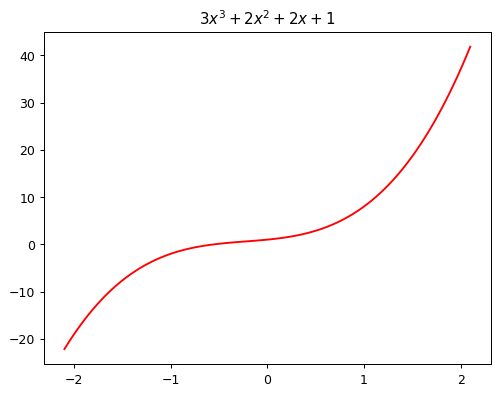

In [14]:
def cubic(x):return 3*x**3 + 2*x**2 + 2*x + 1
plot_function(cubic, "$3x^3 + 2x^2 + 2x + 1$")

In [15]:
def cubic_general(a, b, c, d, x): return a*x**3 + b*x**2 + c*x + d

`partial` fixes the variables passed as parameters. In this case only `x` is variable

In [16]:
def mk_cubic(a, b, c, d): return partial(cubic_general, a, b, c, d)

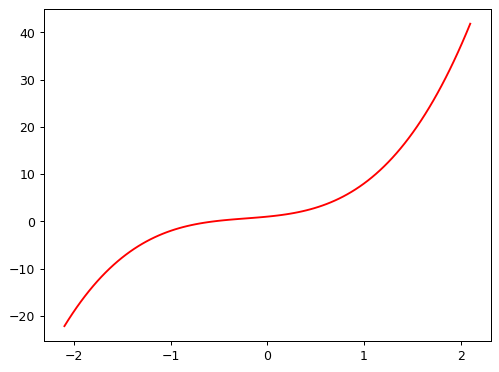

In [17]:
cubic1 = mk_cubic(3, 2, 2, 1)
plot_function(cubic1)

## Generate random data and add noise

In [18]:
import numpy as np
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape) #scale-> std dev
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [19]:
import torch
np.random.seed(42)
x = torch.linspace(-1,1,steps=100)[:None]
y = cubic1(x)
y = add_noise(y, 0.5, 1)

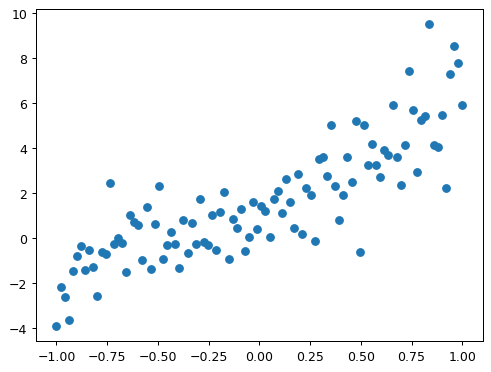

In [20]:
plt.scatter(x, y)

In [21]:
x.shape, y.shape

(torch.Size([100]), torch.Size([100]))

Make an interactive plot

In [22]:
@interact(a=1.1, b=1.1, c=1.1, d=1.1)
def plot_quad(a, b, c, d):
    plt.scatter(x,y)
    plot_function(mk_cubic(a,b,c,d), ylim=(-5,11))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [23]:
def mse(act, pred): return ((act-pred)**2).mean()

In [24]:
@interact(a=1.1, b=1.1, c=1.1, d=1.1)
def plot_quad(a, b, c, d):
    f = mk_cubic(a,b,c,d)
    plt.scatter(x,y)
    loss = mse(f(x), y)
    plot_function(f, ylim=(-5,11), title=f"MSE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

## Automate gradient descent

Define the parameters and set `requires_grad=True` to allow gradient computation

In [26]:
abcd = torch.tensor([1.1, 1.1, 1.1, 1.1])
abcd

tensor([1.1000, 1.1000, 1.1000, 1.1000])

In [27]:
abcd.requires_grad_()

tensor([1.1000, 1.1000, 1.1000, 1.1000], requires_grad=True)

### Steps:
- Do a forward pass to get the y values.
- Compute loss
- Do `loss.backward`
- Modify parameters

In [28]:
def compute_mse(params):
    cubic = mk_cubic(*params)
    return mse(cubic(x), y)

In [29]:
loss = compute_mse(abcd)
loss

tensor(3.1997, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [30]:
loss.backward()

In [31]:
abcd

tensor([1.1000, 1.1000, 1.1000, 1.1000], requires_grad=True)

In [32]:
abcd.grad

tensor([-0.8900, -0.1419, -1.3660, -0.3133])

A large negative value indicates that that particular param needs to be increased by a lot.

In [33]:
with torch.no_grad():
    abcd -= 0.01*abcd.grad
    print(compute_mse(abcd))

tensor(3.1721, dtype=torch.float64)


In [34]:
for i in range(10):
    loss = compute_mse(abcd)
    loss.backward()
    with torch.no_grad(): abcd -= (0.01*abcd.grad)
    print(f"Epoch {i+1} Loss: {loss:.2f}")

Epoch 1 Loss: 3.17
Epoch 2 Loss: 3.12
Epoch 3 Loss: 3.04
Epoch 4 Loss: 2.94
Epoch 5 Loss: 2.82
Epoch 6 Loss: 2.69
Epoch 7 Loss: 2.56
Epoch 8 Loss: 2.42
Epoch 9 Loss: 2.28
Epoch 10 Loss: 2.15


In [38]:
abcd = torch.tensor([1.1, 1.1, 1.1, 1.1])
abcd.requires_grad_()

for i in range(10):
    loss = compute_mse(abcd)
    loss.backward()
    with torch.no_grad(): abcd -= (0.03*abcd.grad)
    print(f"Epoch {i+1} Loss: {loss:.2f}")

Epoch 1 Loss: 3.20
Epoch 2 Loss: 3.12
Epoch 3 Loss: 2.96
Epoch 4 Loss: 2.76
Epoch 5 Loss: 2.52
Epoch 6 Loss: 2.28
Epoch 7 Loss: 2.07
Epoch 8 Loss: 1.90
Epoch 9 Loss: 1.81
Epoch 10 Loss: 1.79


In [39]:
abcd

tensor([2.2300, 1.2379, 2.8293, 1.3621], requires_grad=True)

## Rectified Linear function

In [41]:
def rectified_linear(m,b,x):
	y = m*x + b
	return torch.clip(y, 0.0)

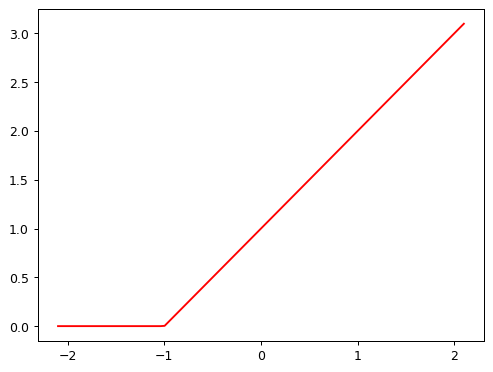

In [42]:
plot_function(partial(rectified_linear, 1,1))

In [46]:
@interact(m=1.1, b=1.1)
def plot_rectified_linear(m, b):
    f = partial(rectified_linear, m, b)
    plot_function(f, ylim=(-0.1,3))

interactive(children=(FloatSlider(value=1.1, description='m', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [47]:
def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)

In [49]:
@interact(m1=1.1, b1=1.1, m2=-1.5, b2=-1.5)
def plot_rectified_linear(m1, b1, m2, b2):
    f = partial(double_relu, m1, b1, m2, b2)
    plot_function(f, ylim=(-0.1,3))

interactive(children=(FloatSlider(value=1.1, description='m1', max=3.3000000000000003, min=-1.1), FloatSlider(…